In [12]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from images import get_images_eval, create_batch, images_train, images_valid, BATCH_SIZE
from tensorflow.keras import layers, models, optimizers
import numpy as np

resnet_triplet_net_dir = './result/resnet_imagenet/resnet_triplets-l2-norm'

images_eval = get_images_eval()
input_shape = images_eval.shape[1:]
# input = layers.Input(input_shape)
resnet_base = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")
decoder = models.Sequential(name='decoder')
decoder.add(layers.Flatten())
decoder.add(layers.Dense(2048))
decoder.add(layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))
# decoder.add(layers.Dense(1024, activation='relu'))
# decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
# decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))
resnet_embedding = Model(inputs=resnet_base.inputs, outputs=decoder(resnet_base.output), name='ResNet50')
resnet_embedding.summary(), #resnet_embedding.layers #, decoder.summary()
# tf.keras.utils.plot_model(resnet_embedding, to_file="model.png", show_shapes=True, layer_range=["input_7", "conv2_block1_out"])
# from tensorflow.keras import optimizers

# tf.keras.utils.plot_model(resnet_embedding, to_file="model.png", show_shapes=True)
# predict_and_print(resnet_embedding, images_eval, "images_eval_resnet")

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

(None,)

In [13]:
input_a = layers.Input(name="anchor", shape=images_eval.shape[1:])
input_p = layers.Input(name="positive", shape=images_eval.shape[1:])
input_n = layers.Input(name="negative", shape=images_eval.shape[1:])

embedding_a = resnet_embedding(input_a)
embedding_p = resnet_embedding(input_p)
embedding_n = resnet_embedding(input_n)

output = layers.concatenate([embedding_a, embedding_p, embedding_n], axis=1)
# print(output)

siamese_net = models.Model([input_a, input_p, input_n], output)
siamese_net.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
ResNet50 (Functional)           (None, 2048)         27784064    anchor[0][0]                     
                                                                 positive[0][0]             

In [14]:
import tensorflow as tf
from metrics import get_callbacks
from utils.utils import plot_log

emb_size = 2048
alpha = 0.2
def triplet_loss(y_true, y_pred):
    # tf.print(y_pred, y_pred.shape)
    anchor, positive, negative = y_pred[:, :emb_size], y_pred[:, emb_size:2*emb_size], y_pred[:, 2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    L = tf.maximum(positive_dist - negative_dist + alpha, 0.)
    return L


def accuracy(y_true, y_pred):
    anchor, positive, negative = y_pred[:, :emb_size], y_pred[:, emb_size:2*emb_size], y_pred[:, 2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return positive_dist + alpha < negative_dist

def data_generator(images):
    while True:
        x = create_batch(images, (32, 32, 3))
        y = np.zeros((100, 3*emb_size))
        yield [x[0], x[1], x[2]], y

# data_generator().send(None)[0][0].shape

lr = 0.01
optimiser_obj = optimizers.Adam(learning_rate=lr)
siamese_net.compile(loss=triplet_loss, optimizer=optimiser_obj, metrics=[accuracy])

net_callbacks = get_callbacks(resnet_triplet_net_dir, lr, 0.9, 'val_accuracy')
weights_file = resnet_triplet_net_dir + '/trained_model.h5'
run_fit = True
if(run_fit):
    siamese_net.fit(
        data_generator(images_train),
        steps_per_epoch=int(len(images_train)/BATCH_SIZE), 
        epochs=10, 
        validation_data=data_generator(images_valid),
        validation_steps=int(len(images_valid)/BATCH_SIZE),
        callbacks=[net_callbacks])
    siamese_net.save_weights(weights_file)
    print('Trained model saved to \'%s\'' % weights_file)
else:
    siamese_net.load_weights(weights_file)

plot_log(resnet_triplet_net_dir + '/log.csv', show=True)

Epoch 1/10
36/36 [==============================] - 155s 4s/step - loss: 0.1993 - accuracy: 0.0000e+00 - val_loss: 0.2000 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to ./result/resnet_imagenet/resnet_triplets-l2-norm\weights-01.h5
Epoch 2/10
36/36 [==============================] - 107s 3s/step - loss: 0.1992 - accuracy: 0.0000e+00 - val_loss: 0.2000 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.00000
Epoch 3/10
36/36 [==============================] - 113s 3s/step - loss: 0.1993 - accuracy: 0.0000e+00 - val_loss: 0.2000 - val_accuracy: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.00000
Epoch 4/10
36/36 [==============================] - 110s 3s/step - loss: 0.1993 - accuracy: 0.0000e+00 - val_loss: 0.2000 - val_accuracy: 0.0000e+00

Epoch 00004: val_accuracy did not improve from 0.00000
Epoch 5/10
23/36 [==================>...........] - ETA: 36s - loss: 0.1991 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [16]:
from images import get_images_eval, predict_and_print, create_batch, images_train, images_valid, images_test, preprocess_image_with_angle

shape = images_eval.shape[1:]
x_a = np.zeros((BATCH_SIZE, *shape))  # * - expands tuple
x_p = np.zeros((BATCH_SIZE, *shape))  # * - expands tuple
x_n = np.zeros((BATCH_SIZE, *shape))  # * - expands tuple
for i in range(10):
    for angle in range(10):
        image_a = preprocess_image_with_angle(
            images_test[i*3], angle, 10)
        image_p = preprocess_image_with_angle(
            images_test[i*3+1], 0, 10)
        image_n = preprocess_image_with_angle(
            images_test[i*3+2], 0, 10)
        x_a[i*10 + angle] = image_a
        x_p[i*10 + angle] = image_p
        x_n[i*10 + angle] = image_n
images_test_eval = np.array([x_a, x_p, x_n])
images_test_eval.shape, len(images_test)

((3, 100, 32, 32, 3), 30)

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import combine_images
file_name = "triplet_recon"
x_recon = siamese_net.predict([x_a, x_p, x_n], batch_size=100)

accuracy 76.0 76 24


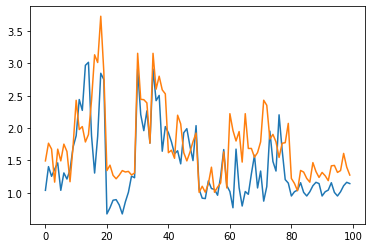

In [20]:

tp = 0
fp = 0
xaxis = []
yaxis = []
for i in range(0, 100):
    embedding_img_a = x_recon[i, :emb_size]
    embedding_img_p = x_recon[i, emb_size:2*emb_size]
    embedding_img_n = x_recon[i, 2*emb_size:]
    # embedding_img_a.shape, embedding_img_p.shape, embedding_img_n.shape
    p = np.mean(np.square(embedding_img_a - embedding_img_p))
    n = np.mean(np.square(embedding_img_a - embedding_img_n))
    pda = np.nansum(p)
    nda = np.nansum(n)
    xaxis.append(i)
    yaxis.append([pda, nda])
    # print(pda, nda)
    if pda < nda:
        tp += 1
    else:
        fp +=1 
    # print(np.max(p), np.max(n), np.max(p - n), np.max(p - n + 0.2), p < n)
    
print('accuracy', np.round(tp / (tp + fp) * 100, 1), tp, fp)
plt.plot(xaxis, yaxis)
plt.show()